## DoubleDQN with Prioritized Replay (PER) and Dueling Network Architecture - Watch Trained Models

In [1]:
#Import the various required libraries
import math, random, time

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from collections import namedtuple

#Additional configuration for the IPython Notebooks
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Required Functions and Model Class for Saved Models

In [2]:
 def eval_plot(rewardtuple):
    """
    Function for plotting the performance of the 
    beginner, intermediate and professional agents
    """
    clear_output(True)
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    avg_rewards = []
    
    agent_name = rewardtuple.labels
    rewards = rewardtuple.values
    
    for agent_id, agent_reward in enumerate(rewards):
        ax.plot(agent_reward, label=agent_name[agent_id])
        avg_rewards.append(np.mean(agent_reward))
    
    avg_rewards = np.around(avg_rewards, decimals=1)
    plt.title('Track Agents Evaluation Progress : Beg: {begin_avg}, Int: {inter_avg}, Pro: {pro_avg}'
             .format(begin_avg=avg_rewards[0], inter_avg=avg_rewards[1], pro_avg=avg_rewards[2]))
    ax.legend(loc='right', frameon=False)
    
    ax.set_yticks(np.arange(0,100, 5), minor=True)
    ax.set_yticks(np.arange(0,100, 10))
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    plt.show()
    
class DuelingDQN(nn.Module):
    """
    Class for implementing the duelling DQN architcture
    Used here for the purpose of loading the class
    """
    def __init__(self, num_inputs, num_outputs):
        super(DuelingDQN, self).__init__()
        
        
        self.feature = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

### Watch the Trained Agent Play - beginner, intermediate, professional

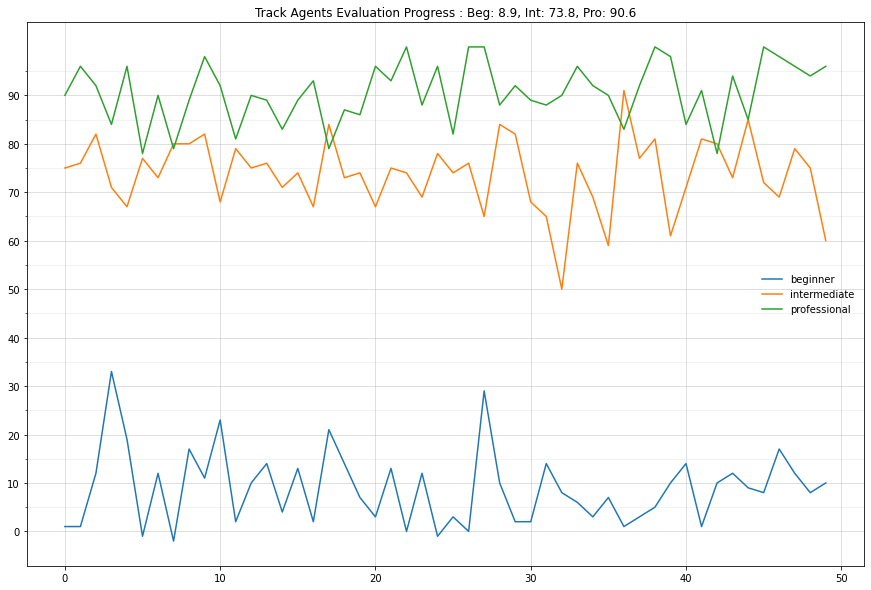

Beginner took: 584.4736201763153 Intermediate took: 357.29928827285767 Progessional took: 132.52619242668152


In [19]:
# Configure Environment and create 3 copies - 1 for each agent #
################################################################
env_id = "Boxing-ram-v0"
env    = gym.make(env_id)
env1   = gym.make(env_id)
env2   = gym.make(env_id)
env3   = gym.make(env_id)

# Load these models for evaluation #
####################################
beginner     = torch.load( "./models/openai_%s_250000.model" % env_id)
intermediate = torch.load( "./models/openai_%s_500000.model" % env_id)
professional = torch.load( "./models/openai_%s_5000000.model" % env_id)

# Place all models into Eval model #
####################################
beginner.eval()
intermediate.eval()
professional.eval()

# parameter/toggles for script #
################################
num_episodes    = 50
render          = True

all_rewards1    = []
episode_reward1 = 0
games_played1   = 0

all_rewards2    = []
episode_reward2 = 0
games_played2   = 0

all_rewards3    = []
episode_reward3 = 0
games_played3   = 0

frame_idx       = 0
state1          = env1.reset()
state2          = env2.reset()
state3          = env3.reset()
gaming          = True
skip1           = False
skip2           = False
skip3           = False
t               = time.time()

# Build a named tuple for plotting #
####################################
reward_tuple    = namedtuple("Point",["labels", "values"])

# Start evaluation #
####################
while gaming:
    env1.render()
    env2.render()
    env3.render()
    
    # Until all games played, make beginner agent play
    if games_played1 < num_episodes:
        action1 = beginner.act(state1, 0.01)
        next_state1, reward1, done1, _ = env1.step(action1) 
        state1 = next_state1
        episode_reward1 += reward1
    
    # If the beginner agent's last action ended the game, reset it's env
    if done1 and games_played1 < num_episodes:
        state1 = env1.reset()
        all_rewards1.append(episode_reward1)
        episode_reward1 = 0
        games_played1 += 1

    # Until all games played, make intermediate agent play
    if games_played2 < num_episodes:
        action2 = intermediate.act(state2, 0.01)
        next_state2, reward2, done2, _ = env2.step(action2)
        state2 = next_state2
        episode_reward2 += reward2
    
    # If the intermediate agent's last action ended the game, reset it's env
    if done2 and games_played2 < num_episodes:
        state2 = env2.reset()
        all_rewards2.append(episode_reward2)
        episode_reward2 = 0
        games_played2 += 1

    # Until all games played, make professional agent play
    if games_played3 < num_episodes:
        action3 = professional.act(state3, 0.01)
        next_state3, reward3, done3, _ = env3.step(action3)
        state3 = next_state3
        episode_reward3 += reward3
    
    # If the professional agent's last action ended the game, reset it's env
    if done3 and games_played3 < num_episodes:
        state3 = env3.reset()
        all_rewards3.append(episode_reward3)
        episode_reward3 = 0
        games_played3 += 1

    # Plot eval metrics as required
    if frame_idx % 200 == 0:
        eval_plot(reward_tuple(labels=["beginner", "intermediate", "professional"],
                               values=[all_rewards1, all_rewards2, all_rewards3])
                 )
        
    # Once the beginner agent has played all games, calculate time taken
    if games_played1 == num_episodes and not skip1:
        games_duration1 = time.time() - t
        skip1=True
     
    # Once the intermediate agent has played all games, calculate time taken
    if games_played2 == num_episodes and not skip2:
        games_duration2 = time.time() - t
        skip2=True
     
    # Once the profesional agent has played all games, calculate time taken
    if games_played3 == num_episodes and not skip3:
        games_duration3 = time.time() - t
        skip3=True
        
    # End while loop once all agents have finished learning
    if games_played1 == num_episodes and games_played2 == num_episodes and games_played3 == num_episodes:
        gaming = False
    
    frame_idx +=1

# Update performance plot with final status of all agents
eval_plot(reward_tuple(labels=["beginner", "intermediate", "professional"],
                       values=[all_rewards1, all_rewards2, all_rewards3])
         )

#Print time taken for each agent
print("Beginner took: {}".format(games_duration1),
      "Intermediate took: {}".format(games_duration2),
      "Progessional took: {}".format(games_duration3)
     )